In [35]:
# implementacao e treinamento da rede
import torch
from torch import nn, optim

# dados
from torch.utils.data import DataLoader, Dataset
# from torchvision import models, transforms
from backtesting import *
# plots
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, precision_recall_fscore_support

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import warnings
warnings.filterwarnings('ignore')
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
args = {
    'epoch_num': 5,
    'lr': 1e-4,
    'num_workes': 10,  # numero de processos
    'weight_decay': 8e-4,
    'batch_size': 20
}

In [3]:
# Configurando Hardware
if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

cuda


# Carregando base

In [4]:
class HistoricoAcoes(Dataset):
    # , scaler_feat=None, sacaler_label=None):
    def __init__(self, path_x, path_y):
        self.X = np.load(path_x).astype('float32')
        if '.npy' in path_y:
            self.y = np.load(path_y).reshape(-1, 1).astype('int64')
        else:
            self.y = path_y

    def __getitem__(self, index):
        sample = torch.from_numpy(self.X[index])
        label = torch.from_numpy(self.y[index])

        return sample, label

    def __len__(self):
        return self.X.shape[0]

In [5]:
path_train_x = 'base/X_train_balance_torch_2.npy'
path_train_y = 'base/y_train_balance_torch_2.npy'
path_test_x = 'base/X_test_torch_2.npy'
path_test_y = 'base/y_test_torch_2.npy'

In [6]:
train_set = HistoricoAcoes(path_x=path_train_x, path_y=path_train_y)
test_set = HistoricoAcoes(path_x=path_test_x, path_y=path_test_y)

In [7]:
dado, label = train_set[0]

In [8]:
dado, label = test_set[0]

## construindo DataLoader

In [9]:
train_loader = DataLoader(
    train_set,
    batch_size=args['batch_size'],
    shuffle=True
)

In [10]:
test_loader = DataLoader(
    test_set,
    batch_size=args['batch_size'],
    shuffle=True
)

# Construindo Rede

In [13]:
# reference Sezer (2018) "Algorithmic financial trading with deep convolutional neural networks: Time series to image conversion approach"


class CNN_signal(nn.Module):
    # camada convulocional 1
    def __init__(self):
        super(CNN_signal, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=32, kernel_size=3, padding=1)
        # camada convulocional 2
        self.conv2 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=3, padding=1)
        # camada de pooling máxima
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # camada dropout 1
        self.dropout1 = nn.Dropout(0.25)
        # camada dropout 2
        self.dropout2 = nn.Dropout(0.7)  # 0.5
        # camda totalmente conectada 1
        self.fc1 = nn.Linear(64*30*30, 128)
        # camada de saida
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        # Passando pela primeira camada convolucional e pela função de ativação ReLU
        x = nn.functional.relu(self.conv1(x))
        # Passando pela segunda camada convolucional e pela função de ativação ReLU
        x = nn.functional.relu(self.conv2(x))
        # Aplicando pooling máxima
        x = self.pool(x)
        # Aplicando dropout
        x = self.dropout1(x)
        # Achatar o tensor para a camada totalmente conectada
        x = x.view(-1, 64*30*30)
        # Primeira camada totalmente conectada
        x = nn.functional.relu(self.fc1(x))
        # Aplicando dropout
        x = self.dropout2(x)
        # Camada de saída
        x = self.fc2(x)
        return x

In [14]:
# criando rede
net = CNN_signal()

# Criterion

In [15]:
# funcao de perda
criterion = nn.CrossEntropyLoss().to(args['device'])
optimizer = optim.Adam(
    net.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

# Treino

In [16]:
import time
import os


def train(train_loader, net, epoch):

    # Training mode
    net.train()

    start = time.time()

    epoch_loss = []
    pred_list, rotulo_list = np.array([]), np.array([])
    for batch in tqdm(train_loader):

        dado, rotulo = batch
        dado = dado.view(dado.size(0), 1, dado.size(1), dado.size(2))
        rotulo = rotulo.view(-1)
        # Cast do dado na GPU
        dado = dado.to(args['device'], dtype=torch.float32)
        rotulo = rotulo.to(args['device'], dtype=torch.long)

        # Forward
        ypred = net(dado)
        loss = criterion(ypred, rotulo)
        epoch_loss.append(loss.cpu().data)

        _, pred = torch.max(ypred, axis=1)
        # pred_list.append(pred.cpu().numpy())
        # rotulo_list.append(rotulo.cpu().numpy())
        pred_list = np.append(pred.cpu().numpy(), pred_list)
        rotulo_list = np.append(rotulo.cpu().numpy(), rotulo_list)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = np.array(epoch_loss)
    pred_list = np.array(pred_list).ravel()
    rotulo_list = np.array(rotulo_list).ravel()

    acc = accuracy_score(pred_list, rotulo_list)
    precision_recall = precision_recall_fscore_support(pred_list, rotulo_list)

    end = time.time()
    print('#################### Train ####################')
    print('Epoch %d, Loss: %.4f +/- %.4f, Acc: %.2f, Prec 2: %.2f ,Prec 3: %.2f ,Time: %.2f' %
          (epoch, epoch_loss.mean(), epoch_loss.std(), acc*100, precision_recall[0][1]*100, precision_recall[0][2]*100, end-start))

    return epoch_loss.mean()

In [19]:
def validate(test_loader, net, epoch):

    # Evaluation mode
    net.eval()

    start = time.time()

    epoch_loss = []
    pred_list, rotulo_list = np.array([]), np.array([])
    # with torch.no_grad():
    for batch in tqdm(test_loader):

        dado, rotulo = batch

        # Cast do dado na GPU
        dado = dado.view(dado.size(0), 1, dado.size(1), dado.size(2))
        rotulo = rotulo.view(-1)

        dado = dado.to(args['device'], dtype=torch.float32)
        rotulo = rotulo.to(args['device'], dtype=torch.long)
        rotulo[rotulo < 0] = 0

        num_classes = 3  # Supondo que haja 3 classes
        if rotulo.max().item() >= num_classes or rotulo.min().item() < 0:
            print(f"Os rótulos estão fora do intervalo esperado.\n min: {
                  rotulo.min().item()}\n max: {rotulo.max().item()}")
            # raise ValueError("Os rótulos estão fora do intervalo esperado.")

        else:
            # Forward
            ypred = net(dado)
            loss = criterion(ypred, rotulo.view(-1))
            epoch_loss.append(loss.cpu().data)

            _, pred = torch.max(ypred, axis=1)
            # pred_list.append(pred.cpu().numpy())
            # rotulo_list.append(rotulo.cpu().numpy())
            pred_list = np.append(pred.cpu().numpy(), pred_list)
            rotulo_list = np.append(rotulo.cpu().numpy(), rotulo_list)

    epoch_loss = np.asarray(epoch_loss)
    pred_list = np.asarray(pred_list).ravel()
    rotulo_list = np.asarray(rotulo_list).ravel()

    acc = accuracy_score(pred_list, rotulo_list)
    precision_recall = precision_recall_fscore_support(pred_list, rotulo_list)

    end = time.time()
    print('********** Validate **********')
    # print('Epoch %d, Loss: %.4f +/- %.4f, Acc: %.2f, Time: %.2f\n' %
    #       (epoch, epoch_loss.mean(), epoch_loss.std(), acc*100, end-start))
    print('Epoch %d, Loss: %.4f +/- %.4f, Acc: %.2f, Prec 2: %.2f ,Prec 3: %.2f ,Time: %.2f' %
          (epoch, epoch_loss.mean(), epoch_loss.std(), acc*100, precision_recall[0][1]*100, precision_recall[0][2]*100, end-start))

    return epoch_loss.mean()

In [20]:
net.to(args['device'])

CNN_signal(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.7, inplace=False)
  (fc1): Linear(in_features=57600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)

In [21]:
train_loss = []
test_loss = []
epoch_train = 0
epoch_test = 0
# treinamento
for epoch in range(10):  # 36 min 50
    if abs(epoch_train-epoch_test) <= 0.4:
        epoch_train = train(train_loader=train_loader, net=net, epoch=epoch)
        train_loss.append(epoch_train)
        # Validat
        epoch_test = validate(test_loader, net, epoch)
        test_loss.append(epoch_test)

    else:
        break

100%|██████████| 11256/11256 [01:47<00:00, 104.38it/s]


#################### Train ####################
Epoch 0, Loss: 0.6489 +/- 0.1244, Acc: 69.70, Prec 2: 87.29 ,Prec 3: 84.10 ,Time: 107.98


100%|██████████| 163/163 [00:00<00:00, 359.58it/s]


********** Validate **********
Epoch 0, Loss: 0.8391 +/- 0.1346, Acc: 49.11, Prec 2: 55.34 ,Prec 3: 66.67 ,Time: 0.46


100%|██████████| 11256/11256 [01:46<00:00, 105.65it/s]


#################### Train ####################
Epoch 1, Loss: 0.5396 +/- 0.1218, Acc: 75.73, Prec 2: 89.60 ,Prec 3: 87.74 ,Time: 106.68


100%|██████████| 163/163 [00:00<00:00, 376.44it/s]


********** Validate **********
Epoch 1, Loss: 0.7423 +/- 0.1702, Acc: 58.68, Prec 2: 51.46 ,Prec 3: 55.86 ,Time: 0.44


100%|██████████| 11256/11256 [01:47<00:00, 105.17it/s]


#################### Train ####################
Epoch 2, Loss: 0.4700 +/- 0.1234, Acc: 79.30, Prec 2: 91.19 ,Prec 3: 89.64 ,Time: 107.17


100%|██████████| 163/163 [00:00<00:00, 388.13it/s]


********** Validate **********
Epoch 2, Loss: 0.6851 +/- 0.1912, Acc: 64.28, Prec 2: 42.72 ,Prec 3: 50.45 ,Time: 0.42


100%|██████████| 11256/11256 [01:44<00:00, 107.52it/s]


#################### Train ####################
Epoch 3, Loss: 0.4246 +/- 0.1251, Acc: 81.58, Prec 2: 92.22 ,Prec 3: 90.77 ,Time: 104.82


100%|██████████| 163/163 [00:00<00:00, 400.46it/s]


********** Validate **********
Epoch 3, Loss: 0.6323 +/- 0.2281, Acc: 69.66, Prec 2: 26.21 ,Prec 3: 43.24 ,Time: 0.41


100%|██████████| 11256/11256 [01:42<00:00, 110.12it/s]


#################### Train ####################
Epoch 4, Loss: 0.3938 +/- 0.1241, Acc: 83.01, Prec 2: 92.65 ,Prec 3: 91.45 ,Time: 102.45


100%|██████████| 163/163 [00:00<00:00, 404.44it/s]


********** Validate **********
Epoch 4, Loss: 0.5984 +/- 0.2541, Acc: 75.08, Prec 2: 22.82 ,Prec 3: 34.23 ,Time: 0.41


100%|██████████| 11256/11256 [01:42<00:00, 109.90it/s]


#################### Train ####################
Epoch 5, Loss: 0.3719 +/- 0.1239, Acc: 84.13, Prec 2: 92.95 ,Prec 3: 91.99 ,Time: 102.57


100%|██████████| 163/163 [00:00<00:00, 391.65it/s]


********** Validate **********
Epoch 5, Loss: 0.5914 +/- 0.2611, Acc: 75.54, Prec 2: 26.21 ,Prec 3: 36.04 ,Time: 0.42


100%|██████████| 11256/11256 [01:42<00:00, 109.70it/s]


#################### Train ####################
Epoch 6, Loss: 0.3531 +/- 0.1247, Acc: 85.03, Prec 2: 93.25 ,Prec 3: 92.46 ,Time: 102.76


100%|██████████| 163/163 [00:00<00:00, 381.73it/s]


********** Validate **********
Epoch 6, Loss: 0.5843 +/- 0.2299, Acc: 76.55, Prec 2: 29.13 ,Prec 3: 19.82 ,Time: 0.43


100%|██████████| 11256/11256 [01:42<00:00, 109.85it/s]


#################### Train ####################
Epoch 7, Loss: 0.3386 +/- 0.1234, Acc: 85.76, Prec 2: 93.54 ,Prec 3: 92.73 ,Time: 102.62


100%|██████████| 163/163 [00:00<00:00, 396.59it/s]


********** Validate **********
Epoch 7, Loss: 0.5892 +/- 0.3007, Acc: 76.89, Prec 2: 18.93 ,Prec 3: 32.43 ,Time: 0.42


100%|██████████| 11256/11256 [01:43<00:00, 109.02it/s]


#################### Train ####################
Epoch 8, Loss: 0.3278 +/- 0.1212, Acc: 86.09, Prec 2: 93.50 ,Prec 3: 92.74 ,Time: 103.39


100%|██████████| 163/163 [00:00<00:00, 395.64it/s]


********** Validate **********
Epoch 8, Loss: 0.5927 +/- 0.2532, Acc: 77.23, Prec 2: 24.76 ,Prec 3: 22.97 ,Time: 0.42


100%|██████████| 11256/11256 [01:42<00:00, 109.51it/s]


#################### Train ####################
Epoch 9, Loss: 0.3196 +/- 0.1235, Acc: 86.64, Prec 2: 93.79 ,Prec 3: 93.15 ,Time: 103.06


100%|██████████| 163/163 [00:00<00:00, 383.73it/s]

********** Validate **********
Epoch 9, Loss: 0.5714 +/- 0.3080, Acc: 78.83, Prec 2: 20.39 ,Prec 3: 18.47 ,Time: 0.43


## Convergência

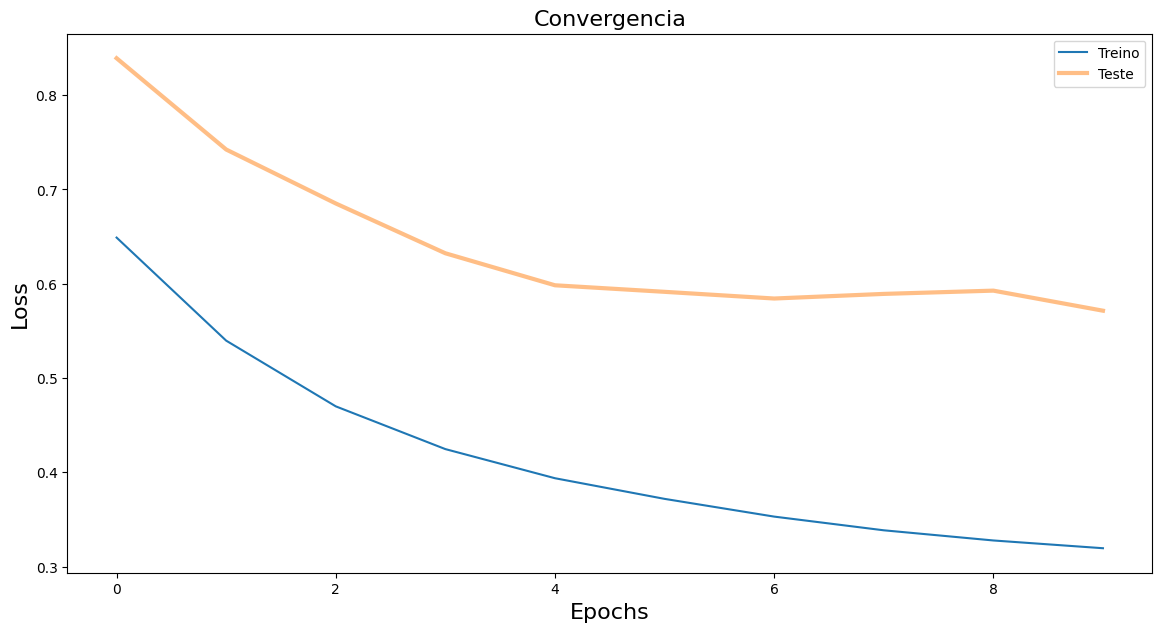

In [22]:
plt.figure(figsize=(14, 7))
plt.plot(train_loss, label='Treino')
plt.plot(test_loss, label='Teste', linewidth=3, alpha=0.5)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Convergencia', fontsize=16)
plt.legend()
plt.show()

In [23]:
# salvando modelo
torch.save(net.state_dict(), 'base/model_2_10_epoch')

# Teste

In [25]:
df_test = pd.read_csv('base/y_test_2.csv')

In [26]:
X_test = torch.from_numpy(test_set.X.astype('float32'))
X_test = X_test.view(X_test.size(0), 1, X_test.size(1), X_test.size(2))

In [27]:
net.to('cpu')
y_pred = net(X_test)
score, pred = torch.max(y_pred, axis=1)
y_pred = pred.cpu().numpy()
score = score.detach().cpu().numpy()

y_test = test_set.y.astype('int')

In [28]:
y_test.shape

(3250, 1)

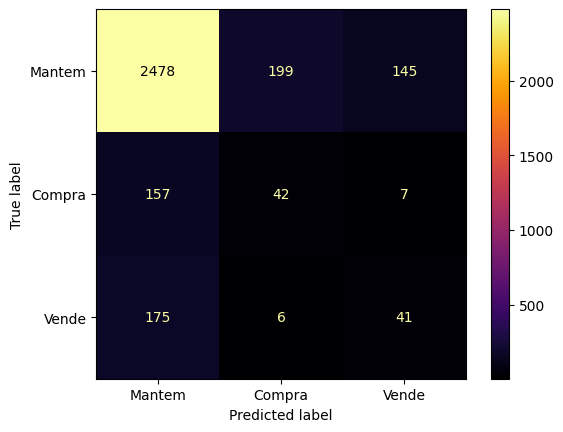

In [29]:
cross = pd.crosstab(y_test.flatten(), y_pred)

matrix = cross.values
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=matrix, display_labels=["Mantem", "Compra", "Vende"])

# display matrix
cm_display.plot(cmap='inferno')

In [31]:
precision, recall, fscore, support = precision_recall_fscore_support(
    y_pred=y_pred,
    y_true=y_test
)

In [32]:
resultado_best = pd.DataFrame(
    {
        'precision': precision,
        'recall': recall,
        'f1score': fscore
    },
    index=['manter', 'comprar', 'vender']
)
resultado_best

,precision,recall,f1score
manter,0.881851,0.878101,0.879972
comprar,0.170040,0.203883,0.185430
vender,0.212435,0.184685,0.197590


# Backtesting

In [33]:
def test_modelos(acao, df_val=None):
    signais = [i for i in df_val.columns if 'signal' in i]
    df_aux = df_val.loc[
        df_val['acao'] == acao,
        ['Date', 'Close']+signais
    ]

    performances = []

    for sinal in signais:
        bkt_l1 = Backtesting(
            df=df_aux,
            sinal=sinal,
            capital_inicial=1000
        )
        bkt_l1.backtesting()
        performance = round(bkt_l1.capital, 1)
        performances.append(performance)
    return performances, signais

In [34]:
# sinal previsto
df_test['signal_pred'] = y_pred

In [36]:
# executando backtesting
acoes = df_test['acao'].unique()
backtest_result = {}
for acao in acoes:
    performance, signais = test_modelos(acao, df_test)
    backtest_result[acao] = performance

In [37]:
df_result = pd.DataFrame(backtest_result, index=[
    signais]).T

In [38]:
df_result.head()

,signal_pred
ABCB4,1000.0
ALUP11,1087.7
ARZZ3,1083.9
B3SA3,991.2
BBAS3,1031.5


In [39]:
df_result.describe()

,signal_pred
count,65.000000
mean,1020.958462
std,71.331558
min,852.700000
25%,993.300000
50%,1014.900000
75%,1044.400000
max,1299.600000


In [40]:
(df_result > 1000).sum() / df_result.shape[0]

signal_pred    0.615385
dtype: float64

In [41]:
resultado_best

,precision,recall,f1score
manter,0.881851,0.878101,0.879972
comprar,0.170040,0.203883,0.185430
vender,0.212435,0.184685,0.197590
